In [1]:
using DelimitedFiles
using StatsBase
using Interpolations
using Plots
using LaTeXStrings
using FFTW
using Distributions
using Profile
using PyCall

In [2]:
# Reading the model into an array

model_2 = readdlm("second_GC_model.txt", comments=true)
numv = size(model_2)[1]

219074

In [3]:
# Histogramming and interpolating the distribution

bsize = 0.3
xbins, ybins, zbins = -30:bsize:30, -30:bsize:30, -3:bsize:3
nubins= fit(Histogram, (vec(model_2[:, 24]), vec(model_2[:, 25]), vec(model_2[:, 26])), (xbins, ybins, zbins), closed=:left)

binvals = nubins.weights ./ (numv*bsize^3)
xedges = collect(xbins)
yedges = collect(ybins)
zedges = collect(zbins)
pop!(xedges)
pop!(yedges)
pop!(zedges)
pds = interpolate((xedges, yedges, zedges), binvals, Gridded(Linear()))
probdens = extrapolate(pds, fill(0))

200×200×20 extrapolate(interpolate((::Vector{Float64},::Vector{Float64},::Vector{Float64}), ::Array{Float64, 3}, Gridded(Linear())), fill(0)) with element type Any:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱ 

In [4]:
# Downloading and interpolating the effective area data

eff_a = readdlm("EffA_GC_approx.csv", ',')
itp = interpolate((eff_a[:, 1],), eff_a[:, 2], Gridded(Linear())) # in m^2
effarea = extrapolate(itp, fill(0))

31-element extrapolate(interpolate((::Vector{Float64},), ::Vector{Float64}, Gridded(Linear())), fill(0)) with element type Any:
   0.05232991146814947
   0.09646616199111992
   0.1539926526059492
   0.25482967479793467
   0.3924189758484536
   0.6042963902381329
   0.8976871324473142
   1.2863969449369745
   1.715437896342879
   2.371373705661655
   ⋮
  42.169650342858226
  50.4806571666747
  60.42963902381328
  69.78305848598663
  83.53625469578262
  93.0572040929699
 107.46078283213174
 115.47819846894582
 143.30125702369628

In [420]:
# Core functions defs

function oscprob(et, dm2, leff)

    # Norms for the PMNS matrix squared:
    uₑ = [0.674743, 0.302844, 0.0224125]
    uₘ = [0.0946105, 0.360415, 0.544974]
    uₜ = [0.230646, 0.33674,  0.432613]

    # Conversion factor to go from kpc to 1/eV
    convfactor = 3.086e19 * 5.06773093741 * 1e6

    leff = leff*convfactor

    osc1 = (cos((dm2 * leff)/(4*et*1e12)))^2
    osc2 = (cos((dm2 * leff)/(4*et*1e12)))^2
    osc3 = (cos((dm2 * leff)/(4*et*1e12)))^2

    prob_surv = osc1*(uₑ[1]*uₑ[1]) + osc2*(uₑ[2]*uₑ[2]) + osc3*(uₑ[3]*uₑ[3])
    prob_mue = osc1*(uₑ[1]*uₘ[1]) + osc2*(uₑ[2]*uₘ[2]) + osc3*(uₑ[3]*uₘ[3])
    prob_e = 0.666666*prob_mue + 0.333333*prob_surv 
end

function flux(et, x, y, z, γ)
    ϕ₀ = 21.8e-16 * 3.156e8 # TeV^-1 cm^-2, completely random, will be able to calculate this directly I think, should be 21.8e-16
    e0 = 100 # TeV
    # γ = 2.0 Completely random, not sure how to calculate this exactly
    probdens(x, y, z)[1] * ϕ₀ * (et/e0)^(-γ)
end

function cartesian(r, l, b)
    x = 8 - r*cos(l)*cos(b)
    y = r*sin(l)*cos(b)
    z = r*sin(b)
    return [x, y, z]
end

function cartx(r, l, b)
    x = 8 - r*cos(l)*cos(b)
    return x
end

function carty(r, l, b)
    y = r*sin(l)*cos(b)
    return y
end

function cartz(r, l, b)
    z = r*sin(b)
    return z
end

cartz (generic function with 1 method)

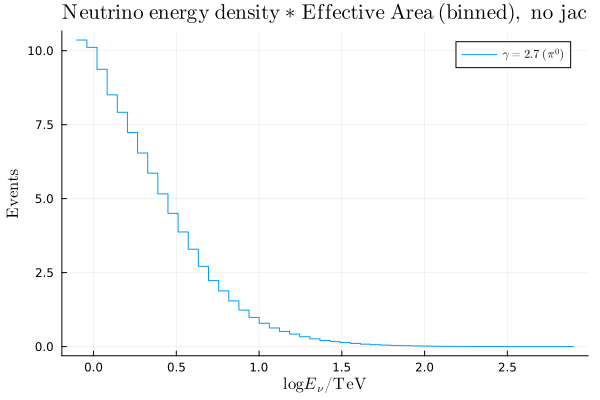

In [493]:
# Plotting idealized all-sky 10 yr flux

emin = 0.7916819159263001
emax = 791.6819159263017

function allskyflux(et, γ)
    ϕ₀ = 21.8e-16 * 3.156e8 # TeV^-1 cm^-2
    e0 = 100 # TeV
    # γ = 2.0 Completely random, not sure how to calculate this exactly
    flx = ϕ₀ * (et/e0)^(-γ) * effarea(et) * 10000
end

function binnedallskyflux(γ)
    emin = 0.7916819159263001
    emax = 791.6819159263017
    nbins = 50
    nsteps = 10000
    us = range(log10(emin), log10(emax), nsteps)    
    du = us[2] - us[1]
    steps = allskyflux.((10 .^ us), γ) .* du # .* (10 .^ us) .* log(10)
    matrix = reshape(steps, (200, :)) # This 2 is the ratio nsteps/nbins
    sums = sum(matrix, dims=1)
    νbins = vec(sums)
end

# Log with jacobian
function logintegral(γ)
    nsteps = 100000
    us = range(log10(emin), log10(emax), nsteps)    
    du = us[2] - us[1]
    steps = allskyflux.((10 .^ us), γ) .* du .* (10 .^ us) .* log(10)
    int = sum(steps)
end

function trueintegral(γ)
    nsteps = 1000000
    es = range(emin, emax, nsteps)
    de = es[2] - es[1]
    steps = allskyflux.(es, γ) .* de
    int = sum(steps)
end



loge_sample = range(log10(emin), log10(emax), 50)
plot(
    loge_sample, 
    [binnedallskyflux(2.7)], 
    seriestype=:step,
    xlabel=L"$\log E_{\nu} / \mathrm{TeV}$",
    ylabel=L"\mathrm{Events}",
    title=L"\textrm{Neutrino~energy~density * Effective~Area~(binned),~no~jac}",
    label=L"$\gamma = 2.7~(\pi^0)$"
)

In [483]:
# Checking that the log and true integrals match

logint = logintegral(2.7)
trueint = trueintegral(2.7)
println("log integral: $logint \ntrue integral: $trueint")

log integral: 665.6816080123169 
true integral: 665.7440508407152


In [26]:
# Energy smearing function OBSOLETE

emin = 0.7916819159263001
emax = 791.6819159263017

function smearedeventdist_obsolete(logereco, dm2, l, b)
    
    function f(ur)
        et = 10^ur
        r0, rmax = 0, 30
        blength = 0.5
        rbins = range(r0, stop=rmax, step=blength)

        flx = flux.(et, cartx.(rbins, l, b), carty.(rbins, l, b), cartz.(rbins, l, b)) .* blength
        probe = oscprob.(et, dm2, rbins)
        effa = effarea(et)[1]*10000

        sum(.*(flx, probe, effa))
    end

    samples = range(-0.5, log10(emax)+0.5, length=300)
    de = samples[2]-samples[1]

    σ = 0.05
    pdf_func(ur) = log(10) * exp10.(ur .- 0) * pdf(Normal(0, σ), abs(1 - exp10(ur - 0)))
    gsample = pdf_func.(samples)
    g_fft = fft(gsample)

    fsample = f.(samples)
    f_fft = fft(fsample)
    C = f_fft .* g_fft
    c = real(ifft(C)) .* de
    
    # Translation factor
    # samples1 = samples .+ 0.5
    
    cut = trunc(Int, (0.5)/de)
    c1 = vcat(c[(cut+1):end], zeros(cut))
    
    fg = interpolate((samples,), c1, Gridded(Linear()))
    fg(logereco) / 2
end

smearedeventdist (generic function with 1 method)

In [206]:
# The good energy smearing function!

emin = 0.7916819159263001
emax = 791.6819159263017

function smearedeventdist(dm2, l, b, σ, γ, θ, nsteps)
    
    function f(ur)
        et = 10^ur
        r0, rmax = 0, 30
        blength = 0.5
        rbins = range(r0, stop=rmax, step=blength)

        flx = flux.(et, cartx.(rbins, l, b), carty.(rbins, l, b), cartz.(rbins, l, b), γ) .* blength .* (pi .* (rbins .* tan(θ)) .^ 2)
        probe = oscprob.(et, dm2, rbins)
        effa = effarea(et)[1]*10000

        sum(.*(flx, probe, effa))
    end

    samples = range(-0.5, log10(emax)+0.5, length=300)
    de = samples[2]-samples[1]

    pdf_func(ur) = log(10) * exp10.(ur .- 0) * pdf(Normal(0, σ), abs(1 - exp10(ur - 0)))
    gsample = pdf_func.(samples)
    g_fft = fft(gsample)

    fsample = f.(samples)
    f_fft = fft(fsample)
    C = f_fft .* g_fft
    c = real(ifft(C)) .* de
    
    # Translation factor
    # samples1 = samples .+ 0.5
    
    cut = trunc(Int, (0.5)/de)
    c1 = vcat(c[(cut+1):end], zeros(cut))
    
    fg = interpolate((samples,), c1, Gridded(Linear()))

    loges = range(log10(emin), log10(emax), nsteps)
    output = fg.(loges) ./ 2
end

smearedeventdist (generic function with 2 methods)

In [487]:
# Testing that the PDF integrates to 1

σ = 1

pdf_func(ur) = log(10) * exp10.(ur .- 0) * pdf(Normal(0, σ), abs(1 - exp10(ur - 0)))
xs = range(-200, 200, 100000)

# Lazy integral
sum(pdf_func.(xs) .* (xs[2]-xs[1]))


0.8413447460668366

In [78]:
# Testing the inside integrand

emin = 0.7916819159263001
emax = 791.6819159263017

dm2 = 0
ur = 0
l, b = 0, 0
γ = 2
θ = 0.122

et = 10^ur
r0, rmax = 0, 30
blength = 0.5
rbins = range(r0, stop=rmax, step=blength)

flx = flux.(et, cartx.(rbins, l, b), carty.(rbins, l, b), cartz.(rbins, l, b), γ) .* blength .* (pi .* (rbins .* tan(θ)) .^ 2)
probe = oscprob.(et, dm2, rbins)
effa = effarea(et)[1]*10000

sum(.*(flx, probe, effa))

flx


61-element Vector{Float64}:
 0.0
 2.4033159340181474e-7
 1.1261251805113605e-6
 2.3483829983834478e-6
 3.4058420093514317e-6
 8.011053113393825e-6
 1.2195111710903522e-5
 1.1776248076688924e-5
 1.5527709806075345e-5
 2.373102819419062e-5
 ⋮
 1.8567332244528774e-5
 0.0
 6.674351679616191e-6
 0.0
 7.177903589600953e-6
 0.0
 0.0
 0.0
 0.0

In [19]:
@time smearedeventdist(0, 0, 0, 0.5, 2, 0.122, 50)

  0.012727 seconds (261.24 k allocations: 8.070 MiB)


50-element Vector{Float64}:
 7.089880261344249e-14
 9.15846424149722e-14
 1.1333669260213883e-13
 1.3321009634493964e-13
 1.4801648417330028e-13
 1.5604942336310302e-13
 1.5816900185470822e-13
 1.5674254192682355e-13
 1.533091169487329e-13
 1.4833861125625164e-13
 ⋮
 2.068767974173012e-15
 1.7148028965553498e-15
 1.4142730907911232e-15
 1.1584095905185468e-15
 9.401202109012925e-16
 7.529364289446846e-16
 5.914090311035968e-16
 4.516070017851439e-16
 3.3067065794428063e-16

In [508]:
# Testing the energy smearing

dm2 = 0
    
function f(ur)

    r0, rmax = 0, 30
    blength = 0.5
    rbins = range(r0, stop=rmax, step=blength)

    et = 10^ur
    flx = flux.(et, cartx.(rbins, l, b), carty.(rbins, l, b), cartz.(rbins, l, b), 2) .* blength
    probe = oscprob.(et, dm2, rbins)
    effa = effarea(et)[1]*10000

    sum(.*(flx, probe, effa)) * 30
end

samples = range(-0.5, log10(emax)+0.5, length=3000)
de = samples[2]-samples[1]

σ = 0.01
pdf_func(ur) = log(10) * exp10.(ur .- 0) * pdf(Normal(0, σ), abs(1 - exp10(ur - 0)))
gsample = pdf_func.(samples)
g_fft = fft(gsample)

fsample = f.(samples)
f_fft = fft(fsample)
C = f_fft .* g_fft
c = real(ifft(C)) .* de

# Translation factor
# samples1 = samples .+ 0.5

cut = trunc(Int, (0.5)/de)
c1 = vcat(c[(cut+1):end], zeros(cut))

fg = interpolate((samples,), c1, Gridded(Linear()))


3000-element interpolate((-0.5:0.001299950224954212:3.3985507246376816,), ::Vector{Float64}, Gridded(Linear())) with element type Float64:
 -5.675029642389051e-16
  6.936147340697729e-16
 -8.323376808837275e-16
  3.278906015602563e-16
  4.792247253572976e-16
  5.044470793234712e-16
  1.6394530078012816e-16
  4.1616884044186375e-16
  1.0088941586469424e-16
  1.0088941586469424e-16
  ⋮
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0

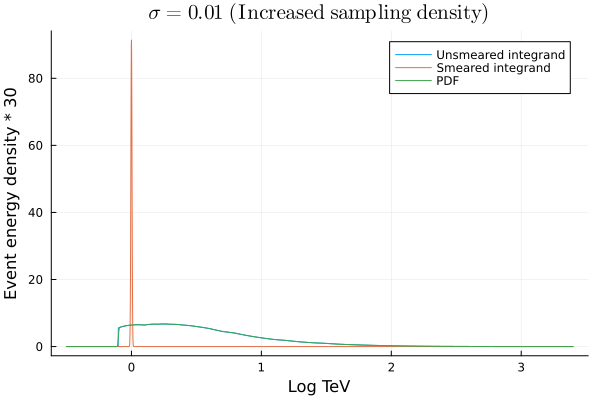

In [511]:
# Plotting the test energy smearing

plot(samples, [fsample gsample fg.(samples)], title=L"\sigma=0.01~(\mathrm{Increased~sampling~density})", label=["Unsmeared integrand" "Smeared integrand" "PDF"])
xlabel!("Log TeV")
ylabel!("Event energy density * 30")

In [135]:
# Approx binned energy distribution function

function apprxedistbinned(dm2, l, b, σ, γ, θ)
    emin = 0.7916819159263001
    emax = 791.6819159263017
    nbins = 500
    us = range(log10(emin), log10(emax), nsteps)    
    dus = (10 .^ us[2:500]) .- (10 .^ us[1:499])
    steps = smearedeventdist(dm2, l, b, σ, γ, θ, nbins-1) .* dus
end

apprxedistbinned (generic function with 1 method)

In [134]:
emin = 0.7916819159263001
emax = 791.6819159263017
nbins = 500
nsteps = 1000
us = range(log10(emin), log10(emax), nsteps)   
dus = (10 .^ us[2:500]) .- (10 .^ us[1:499])
smearedeventdist(0, 0, 0, 0.5, 2, 0.122, 499) .* dus

499-element Vector{Float64}:
 0.0012476149775124809
 0.0012902189615039336
 0.0013343343290203407
 0.0013789997800074583
 0.0014250766392589944
 0.0014718241847971696
 0.0015197640249194962
 0.0015685218995720354
 0.0016182750373789415
 0.001668941466851945
 ⋮
 0.00022113229638430967
 0.00021624770256096148
 0.0002113036257762924
 0.00020642625728440765
 0.0002015223414841399
 0.00019665311514615886
 0.0001917899614799108
 0.00018693031985869566
 0.0001821095973788099

In [478]:
# Binned energy distribution function

function edistbinned(dm2, l, b, σ, γ, θ)
    emin = 0.7916819159263001
    emax = 791.6819159263017
    nbins = 50
    nsteps = 1000
    us = range(log10(emin), log10(emax), nsteps)    
    du = us[2] - us[1]
    steps = smearedeventdist(dm2, l, b, σ, γ, θ, nsteps) .* du .* (10 .^ us) .* log(10)
    matrix = reshape(steps, (20, :)) # This 2 is the ratio nsteps/nbins
    sums = sum(matrix, dims=1)
    νbins = vec(sums)
end

edistbinned (generic function with 1 method)

In [856]:
@time edistbinned(0, 0, 0, 0.5, 2.7, 0.07)

  0.058725 seconds (261.55 k allocations: 8.109 MiB)


50-element Vector{Float64}:
 0.22358557666777534
 0.3159117945825956
 0.42381813077456665
 0.5342403697136847
 0.6298327873114561
 0.6989157359099315
 0.7430822281377255
 0.7717349810366246
 0.7913727190078941
 0.8031232900957886
 ⋮
 0.049825797522802875
 0.04340717560935876
 0.03769532266368216
 0.0325883871658205
 0.028003812297554772
 0.02386108557219539
 0.02007581848648391
 0.016581306719167774
 0.01332046138020517

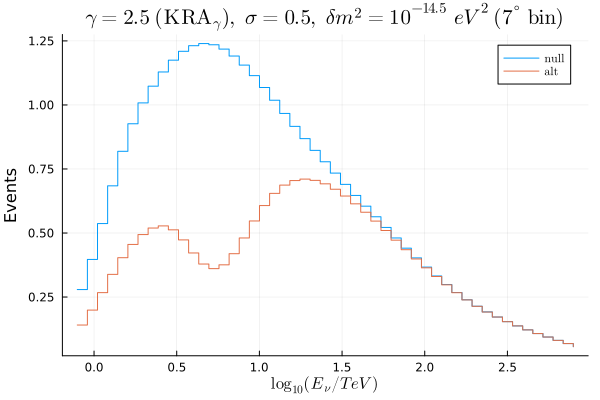

In [480]:
# Plotting KRA_gamma spectral index

emin = 0.7916819159263001
emax = 791.6819159263017

loges = range(log10(emin), log10(emax), 50)

plot(
    loges, 
    [edistbinned(0, 0, 0, 0.5, 2.5, 0.122), edistbinned(10^(-14.0), 0, 0, 0.5, 2.5, 0.122)],
title=L"$\gamma = 2.5~(\mathrm{KRA}_{\gamma}),~\sigma = 0.5,~\delta m^2 = 10^{-14.5}~eV^2~(7^{\circ}~\mathrm{bin})$",
    seriestype=:step, 
    label=[L"$\mathrm{null}$" L"$\mathrm{alt}$"]
)
xlabel!(L"$\log_{10} (E_{\nu}/TeV)$")
ylabel!("Events")

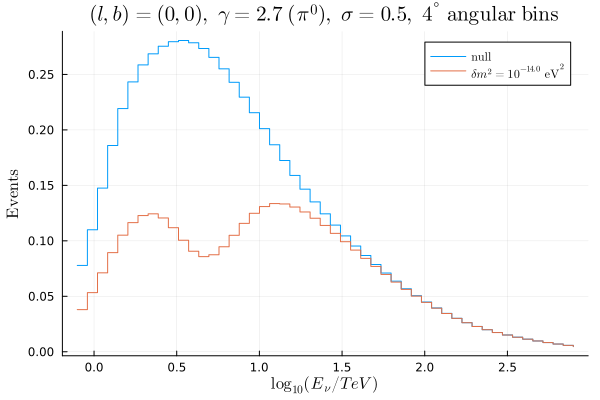

In [662]:
# Plotting pi^0 spectral index

plot(
    loges, 
    [edistbinned(0, 0, -0.03, 0.5, 2.7, 0.07), edistbinned(10^(-14.0), 0, -0.03, 0.5, 2.7, 0.07)],
    title=L"$(l, b) = (0, 0),~\gamma = 2.7~(\pi^0),~\sigma = 0.5, ~4^{\circ}~\mathrm{angular~bins}$",
    seriestype=:step, 
    label=[L"$\mathrm{null}$" L"$\delta m^2 = 10^{-14.0}~\mathrm{eV}^2$"]
)
xlabel!(L"$\log_{10} (E_{\nu}/TeV)$")
ylabel!(L"\mathrm{Events}")

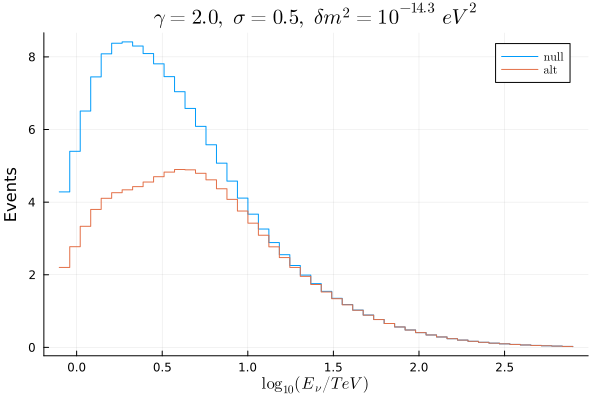

In [143]:
# Plotting initial spectral index (gamma = 2)

plot(
    loges, 
    [edistbinned(0, 0, 0, 0.5, 2.0), edistbinned(10^(-14.3), 0, 0, 0.5, 2.0)],
    title=L"$\gamma = 2.0,~\sigma = 0.5,~\delta m^2 = 10^{-14.3}~eV^2$",
    seriestype=:step, 
    label=[L"$\mathrm{null}$" L"$\mathrm{alt}$"]
)
xlabel!(L"$\log_{10} (E_{\nu}/TeV)$")
ylabel!("Events")

In [631]:
# Loading an all sky event distribution sample

# Define the range of x and y values
l_range = (0):0.07:(2*pi)
b_range = (0):0.07:(pi)

# Create empty arrays to store the function values
function_values = []

# Evaluate the function on the grid of points
for l in l_range
    for b in b_range
        # I'm making the angular sampling of 0.07 rad be the same as the bin width, 
        # so (I think?) this then gets the whole sky
        push!(function_values, edistbinned(10^(-14.0), l, (pi/2 - b), 0.5, 2.7, 0.07))
    end
end

# Convert the list of function values to a 2D array
edistvals = reshape(function_values, length(b_range), length(l_range))
edistvals1 = edistvals'

90×45 adjoint(::Matrix{Any}) with eltype Any:
 [3.47684e-7 4.91964e-7 … 2.66917e-8 2.14425e-8]  …  [1.11386e-6 1.57608e-6 … 8.55106e-8 6.86943e-8]
 [3.47684e-7 4.91964e-7 … 2.66917e-8 2.14425e-8]     [1.11602e-6 1.57914e-6 … 8.5677e-8 6.88279e-8]
 [3.47684e-7 4.91964e-7 … 2.66917e-8 2.14425e-8]     [1.11766e-6 1.58145e-6 … 8.58023e-8 6.89286e-8]
 [3.47684e-7 4.91964e-7 … 2.66917e-8 2.14425e-8]     [1.11875e-6 1.583e-6 … 8.58861e-8 6.89959e-8]
 [3.47684e-7 4.91964e-7 … 2.66917e-8 2.14425e-8]     [1.11929e-6 1.58377e-6 … 8.5928e-8 6.90296e-8]
 [3.47684e-7 4.91964e-7 … 2.66917e-8 2.14425e-8]  …  [1.11929e-6 1.58377e-6 … 8.59279e-8 6.90295e-8]
 [3.47684e-7 4.91964e-7 … 2.66917e-8 2.14425e-8]     [1.11874e-6 1.58299e-6 … 8.58858e-8 6.89957e-8]
 [3.47684e-7 4.91964e-7 … 2.66917e-8 2.14425e-8]     [1.11765e-6 1.58145e-6 … 8.58022e-8 6.89285e-8]
 [3.47684e-7 4.91964e-7 … 2.66917e-8 2.14425e-8]     [1.11603e-6 1.57915e-6 … 8.56774e-8 6.88282e-8]
 [3.47684e-7 4.91964e-7 … 2.66917e-8 2.14425e-8] 

In [634]:
# Now the data are split into all-sky maps for each energy bin

matrix = zeros(length(l_range), length(b_range))
ebins = [copy(matrix) for _ in 1:50]
for i in 1:50
    for j in 1:length(l_range)
        for k in 1:length(b_range)
            ebins[i][j, k] = edistvals1[j, k][i]
        end
    end
end

In [567]:
# Importing the necessary python libraries

@pyimport matplotlib.pyplot as plt
@pyimport numpy as np
@pyimport healpy as hp

In [635]:
# Converting from angles to the appropriate pixels in the Healpix scheme

nside = 150
npix = hp.nside2npix(nside)
thedges = np.arange(0, np.pi, 0.07)
phedges = np.arange(0, 2*np.pi, 0.07)
theta, phi = np.meshgrid(thedges, phedges)
pixel_indices = hp.ang2pix(nside, vec(theta), vec(phi)) .+ 1 # the addition is for changing indexing to Julia indexing

4050-element Vector{Int64}:
      1
      1
      1
      1
      1
      1
      1
      1
      1
      1
      ⋮
 269776
 269777
 269777
 269778
 269778
 269779
 269779
 269780
 269780

In [636]:
# Testing one bin

# bin = reshape(ebins[1], 45, 90)
bin = ebins[1]
e = []

for (i, phval) in enumerate(phedges)
    for (j, thval) in enumerate(thedges)
        push!(e, bin[i, j])
    end
end

E = zeros(hp.nside2npix(nside))

270000-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [665]:
# Smooths the sky by whatever number of degrees we want for a given energy bin

function dist(index)

    # bin = reshape(ebins[index], 45, 90)
    bin = ebins[index]
    e = []
    
    for (j, thval) in enumerate(thedges)
        for (i, phval) in enumerate(phedges)
                push!(e, bin[i, j])
        end
    end

    E = np.zeros(hp.nside2npix(nside))

    # E[pixel_indices] = e
    
    for (i, eval) in enumerate(e)
        E[pixel_indices[i]] = eval
    end
    
    E_smoothing = hp.smoothing(E, fwhm=np.radians(7.))

    twod_array = hp.cartview(E_smoothing, return_projected_map=true) 
end


dist (generic function with 1 method)

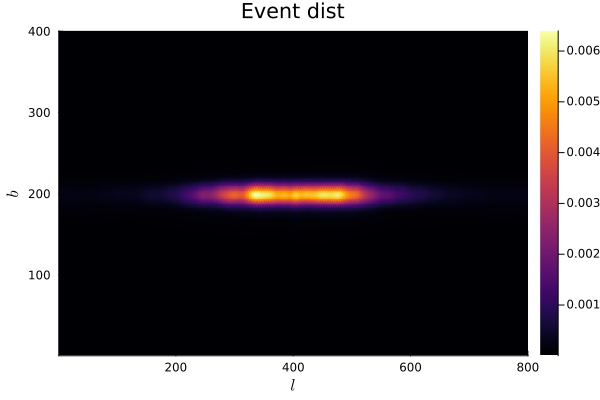

In [655]:
# Plotting an unbinned smeared skymap

hm = heatmap(dist(16), xlabel=L"$l$", ylabel=L"$b$", title="Event dist")

In [840]:
# Binning into angular bins
# For this 400x800 matrix, each pixel represents a 0.007854 radian^2 angular bin, so 16 pixels is 7.2 degrees

function bin7ish(index)
    ebin = dist(index)

    bsize_l = 16
    bsize_b = 16

    nbins_l = convert(Int, (size(ebin, 1)/bsize_l))
    nbins_b = convert(Int, (size(ebin, 2)/bsize_b))

    binned_mat = reshape(ebin, bsize_l, nbins_l, bsize_b, nbins_b)

    bins = sum(binned_mat, dims=(1, 3))

    binned_sums = reshape(bins, nbins_l, nbins_b)
end

bin7ish (generic function with 1 method)

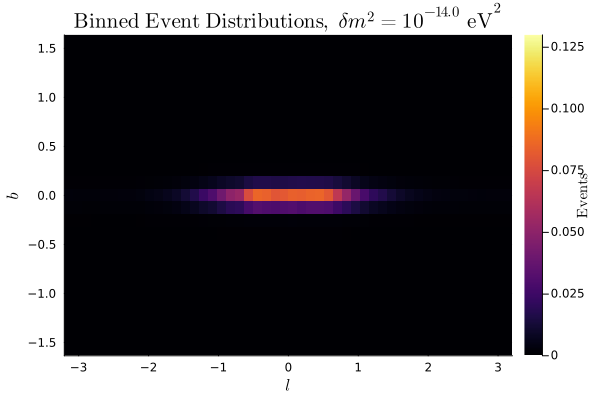

In [805]:
# Printing a single binned skymap

lvals = range(-pi, pi, length=50)
bvals = range(-pi/2, pi/2, length=25)

hm_binned = heatmap(
    lvals, 
    bvals, 
    bin7ish(4), 
    xlabel=L"l", 
    ylabel=L"b", 
    title=L"\textrm{Binned~Event~Distributions},~\delta m^2 = 10^{-14.0}~\textrm{eV}^2",
    colorbar_title=L"\textrm{Events}",
    clims=(0, 0.13),
    colorbar_width=(5, :mm),
    # colorbar_ticks=([0, 0.13], ["0", "0.13"]),
    # aspect_ratio=:equal,
    )


In [841]:
# Making a gif where each frame is a different energy bin

logebins = range(log10(emin), log10(emax), length=50)
veclogebins = collect(logebins)

# These lengths are dependent on the angular bin size
lvals = range(-pi, pi, length=50)
bvals = range(-pi/2, pi/2, length=25)

anim = @animate for ebin in 1:50
    allsky_ebin = bin7ish(ebin)
    loge = round(veclogebins[ebin], digits=3)
    hm_binned = heatmap(
        lvals, 
        bvals, 
        allsky_ebin, 
        xlabel=L"l", 
        ylabel=L"b", 
        title="E = $loge log TeV",
        colorbar_title=L"\textrm{Events}",
        clims=(0, 0.15),
        )
    frame_delay = 50
end

gif(anim, "test_allsky_edist.gif", fps=2)

Animation("/var/folders/f1/m1ggk_2j6sg3vl8gbd6xc_080000gn/T/jl_Emo2H5", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000041.png", "000042.png", "000043.png", "000044.png", "000045.png", "000046.png", "000047.png", "000048.png", "000049.png", "000050.png"])

In [ ]:
@time bin7ish(15)